In [1]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
#DQN
class LSTM_(torch.nn.Module):
    def __init__(self,n_features,seq_length, linear_output):
        super(MV_LSTM_v2, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.linear_outputs = linear_output
       
        self.n_hidden = 512 #90
        
        self.lstm   = nn.LSTMCell(n_features, self.n_hidden)
        self.lstm_1 = nn.LSTMCell(self.n_hidden, self.n_hidden)

        self.fc = nn.Linear(self.n_hidden,self.linear_outputs) 
        
        
    def forward(self, x, future = 0):
        outputs = []
        n_batches = x.size(0)
        
        #first LSTM
        hidden_state   = torch.zeros(n_batches, self.n_hidden, dtype = torch.float32, device=device)
        #print('h1_size',hidden_state.shape)
        cell_state     = torch.zeros(n_batches, self.n_hidden, dtype = torch.float32, device=device)
        #print('c1_size',cell_state.shape)
        
        
        #second LSTM
        hidden_state_1 = torch.zeros(n_batches, self.n_hidden, dtype = torch.float32, device=device)
        #print('h2_size',hidden_state_1.shape)
        cell_state_1   = torch.zeros(n_batches, self.n_hidden, dtype = torch.float32, device=device)
        #print('c2_size',cell_state_1.shape)
        
        #print('sample_size: ',x.shape)
        #x = torch.transpose(x, 0, 1)
        x = x.squeeze()
        #x = torch.transpose(x, 0, 1)
        #print('sample_size_1: ',x.shape)
        
        for input_t in torch.split(x, 1):
            #print('input_t ',input_t.shape)
            hidden_state, cell_state = self.lstm(input_t,(hidden_state,cell_state))
            hidden_state_1, cell_state_1 = self.lstm_1(hidden_state,(hidden_state_1,cell_state_1))
            output = self.fc(hidden_state_1)
            outputs.append(output)
        
        for i in range(future):
            hidden_state, cell_state = self.lstm(output,(hidden_state,cell_state))
            hidden_state_1, cell_state_1 = self.lstm_1(hidden_state,(hidden_state_1,cell_state_1))
            output = self.fc(hidden_state_1)
            outputs.append(output)
        
        outputs = torch.cat(outputs,dim=1)
        return outputs

In [65]:
class EnvManager():
    def __init__(self, device,environment):
        self.device = device
        self.env = gym.make(environment).unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
    
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
        
    def num_actions_available(self):
        return self.env.action_space
        
    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action)
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
    
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
       
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        screen_width  = screen.shape[2]
        #print('screen height(top/bottom): ',screen_height)
        #print('screen height(left/right): ',screen_width)
        # Strip off top and bottom
        top = int(screen_height * 0.2)
        #print('top: ',top)
        bottom = int(screen_height * 0.8)
        #print('bottom: ',bottom)
        
        
        #strip off left/right
        left  = int(screen_width * 0.2)
        #print('left: ',left)
        right = int(screen_width * 0.8)
        #print('right: ',right)
        
        screen = screen[:, top:bottom, left:right]
        return screen
    
    
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

(500, 500, 3)
(3, 500, 500)
500


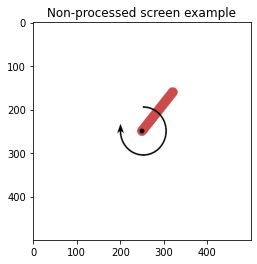

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
environment = 'Pendulum-v0'
em = EnvManager(device,environment)
em.reset()
screen = em.render('rgb_array')
print(screen.shape)
screen1 = screen.transpose((2, 0, 1))
print(screen1.shape)
print(screen1.shape[1])
plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()
em.close()

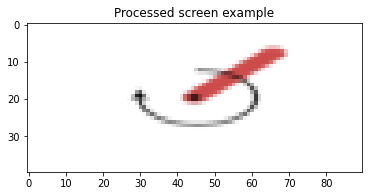

In [67]:
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()
em.close()

In [61]:
import gym
env = gym.make('Pendulum-v0')
env.reset()
for _ in range(1000):
    env.render()
    #print(len(env.action_space.sample()))
    #print('next')
    #a = [-1.4]
    env.step(env.action_space.sample()) # take a random action
env.close()

In [ ]:
#output is a continuous variable

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


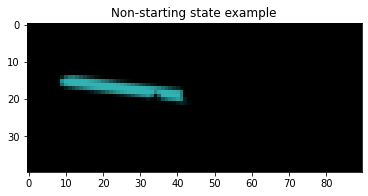

In [78]:
for i in range(5):
    a = [-1.4]
    em.take_action(a)
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non-starting state example')
plt.show()
em.close()

In [27]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)